# Importing Any Necessary Packages 

In [1]:
import json 
from pprint import pprint

import pandas as pd
import matplotlib.pyplot as plt
import graphviz

import numpy as np
from pandas.io.json import json_normalize

import math

In [2]:
pd.set_option('display.max_columns', None)

# Extraction of Data 

In [3]:
def extractDataInfo(filename):
    data = []
    attributes = []
    returnValues = []
    with open(filename) as f:
        for line in f:
            dataLine = json.loads(line)
            data.append(dataLine)
            for key in dataLine.keys():
                attributes.append(key)
        uniqueAttributes = set(attributes)
        returnValues.append(data)
        returnValues.append(uniqueAttributes)
        return returnValues

In [4]:
businessInfo = extractDataInfo('../dataset/business.json') #businessInfo is a list

In [5]:
businessDf = pd.DataFrame.from_dict(businessInfo[0])

In [6]:
originalDf = pd.DataFrame.from_dict(businessInfo[0]) #the original dataset 

# Basic Summary of Raw Business Data

In [325]:
print(businessInfo[0][0])

{'business_id': 'YDf95gJZaq05wvo7hTQbbQ', 'name': 'Richmond Town Square', 'neighborhood': '', 'address': '691 Richmond Rd', 'city': 'Richmond Heights', 'state': 'OH', 'postal_code': '44143', 'latitude': 41.5417162, 'longitude': -81.4931165, 'stars': 2.0, 'review_count': 17, 'is_open': 1, 'attributes': {'RestaurantsPriceRange2': 2, 'BusinessParking': {'garage': False, 'street': False, 'validated': False, 'lot': True, 'valet': False}, 'BikeParking': True, 'WheelchairAccessible': True}, 'categories': ['Shopping', 'Shopping Centers'], 'hours': {'Monday': '10:00-21:00', 'Tuesday': '10:00-21:00', 'Friday': '10:00-21:00', 'Wednesday': '10:00-21:00', 'Thursday': '10:00-21:00', 'Sunday': '11:00-18:00', 'Saturday': '10:00-21:00'}}


In [326]:
businessDf.shape

(156639, 15)

In [327]:
businessDf.dtypes

address          object
attributes       object
business_id      object
categories       object
city             object
hours            object
is_open           int64
latitude        float64
longitude       float64
name             object
neighborhood     object
postal_code      object
review_count      int64
stars           float64
state            object
dtype: object

A brief description of what the variable contains (i.e. "The Tuition column contains information on the annual cost of tuition in $USD"): 
* "business_id":string, 22 character unique string business id
* "name":string, the business's name
* "neighborhood": string, the neighborhood's name
* "address": string, the full address of the business
* "city": string, the city
* "State": string, 2 character state code, if applicable
* "postal code": string, the postal code
* "latitude": float, latitude
* "longitude": float, longitude
* "stars": float, star rating, rounded to half-stars
* "review_count": interger, number of reviews
* "is_open": integer, 0 or 1 for closed or open, respectively
* "attributes": object, business attributes to values. note: some attribute values might be objects
* "categories": an array of strings of business categories
* "hours":an object of key day to value hours, hours are using a 24hr clock
* More description at https://www.yelp.com/dataset/documentation/json

In [328]:
businessDf.describe()

,is_open,latitude,longitude,review_count,stars
count,156639.000000,156638.000000,156638.000000,156639.000000,156639.000000
mean,0.844375,38.585033,-92.856485,30.238159,3.647154
std,0.362501,5.399871,26.557741,96.486631,0.977640
min,0.000000,-36.086009,-142.466650,3.000000,1.000000
25%,1.000000,33.627161,-112.138207,4.000000,3.000000
50%,1.000000,36.142381,-89.523198,9.000000,3.500000
75%,1.000000,43.596845,-79.668760,23.000000,4.500000
max,1.000000,89.999314,115.086769,6979.000000,5.000000


# Expanding DataFrame: Unnesting 
A lot of our data is nested within each dataframe, particularly, the 'attributes', 'hours', and 'categories' columns

## Part I: Unnesting Categories  
Since the # unique Categories is significantly lower than allCategories, it could be significant to group the categories

In [7]:
def findAllCategories():
    allCategories =[]
    for categoryList in businessDf['categories']:
        if(type(categoryList) != str):  
            for category in categoryList:
                allCategories.append(category)
        else:
            allCategories.append(categoryList)
    return allCategories

In [8]:
def findUniqueCategories(allCategoriesList):
    return set(allCategoriesList)

In [9]:
def categoriesStats(allCategoriesList):
    print('Length of all categories is:')
    print(len(allCategoriesList))
    print('Length of all unique categories is:')
    print(len(findUniqueCategories(allCategoriesList)))
    allCategoriesList.remove('Restaurants')
    allCategoriesSeries = pd.Series(allCategoriesList)
    print(allCategoriesSeries.value_counts())
    
    return allCategoriesSeries.value_counts()

In [10]:
originalAllCategories = findAllCategories()
len(originalAllCategories)

590290

In [11]:
statsInfo = categoriesStats(originalAllCategories)

Length of all categories is:
590290
Length of all unique categories is:
1240
Restaurants                  51612
Shopping                     24595
Food                         23014
Beauty & Spas                15139
Home Services                13202
Health & Medical             12033
Nightlife                    11364
Bars                          9868
Automotive                    9476
Local Services                9343
Event Planning & Services     8038
Active Life                   7427
Fashion                       6299
Sandwiches                    5864
Fast Food                     5792
American (Traditional)        5737
Pizza                         5652
Coffee & Tea                  5565
Hair Salons                   5395
Hotels & Travel               5188
Arts & Entertainment          5054
Home & Garden                 4584
Auto Repair                   4480
Italian                       4411
Burgers                       4236
Doctors                       4124
Breakfast & B

In [12]:
def getTopCategories(topNum, frequencyTable):
    statsInfoDict = frequencyTable.to_dict()
    statsInfoList = sorted(statsInfoDict.items(), key=lambda x: x[1], reverse=True)
    
    topCategories =[]
    for i in range(topNum):
        topCategories.append(statsInfoList[i][0])
    
    return topCategories

In [13]:
def reGroup(df, categoryName):
    existList = []
    for categoryArr in df:
        exist = False
        if(type(categoryArr) != str):  
            for category in categoryArr:
                if (category == categoryName):
                    exist = True
        existList.append(exist)
    
    return existList 

In [14]:
def replaceCategory(df, columnName, replacement):
    categoriesDf = df[columnName]
    restaurantsExistList = reGroup(categoriesDf, replacement)
    restaurantsExistSeries = pd.Series(restaurantsExistList)
    categoriesDf.loc[restaurantsExistSeries] = replacement
    print('# of ' + replacement + " made:")
    print(len(categoriesDf.loc[categoriesDf == replacement]))

In [15]:
topCategoriesList = getTopCategories(50, statsInfo)
topCategoriesList

['Restaurants',
 'Shopping',
 'Food',
 'Beauty & Spas',
 'Home Services',
 'Health & Medical',
 'Nightlife',
 'Bars',
 'Automotive',
 'Local Services',
 'Event Planning & Services',
 'Active Life',
 'Fashion',
 'Sandwiches',
 'Fast Food',
 'American (Traditional)',
 'Pizza',
 'Coffee & Tea',
 'Hair Salons',
 'Hotels & Travel',
 'Arts & Entertainment',
 'Home & Garden',
 'Auto Repair',
 'Italian',
 'Burgers',
 'Doctors',
 'Breakfast & Brunch',
 'Mexican',
 'Nail Salons',
 'Professional Services',
 'American (New)',
 'Chinese',
 'Real Estate',
 'Specialty Food',
 'Fitness & Instruction',
 'Pets',
 'Grocery',
 'Bakeries',
 'Cafes',
 'Hair Removal',
 'Dentists',
 'Hotels',
 'Desserts',
 'Skin Care',
 "Women's Clothing",
 'Education',
 'Japanese',
 'Ice Cream & Frozen Yogurt',
 'Pet Services',
 'Day Spas']

In [16]:
def convertedCategories(df, columnName, dataType):
    isStringList =[]
    dataFrame = df[columnName]
    for observation in dataFrame:
        isString = False
        if(type(observation) == dataType):  
            isString = True
        isStringList.append(isString)
    
    isStringSeries = pd.Series(isStringList)
    print("# converted...")
    converted =len(dataFrame.loc[isStringSeries])
    print(converted)
    print("# unconverted..")
    print(len(df) - converted)

In [17]:
for topCategory in topCategoriesList:
    replaceCategory(businessDf, 'categories', topCategory)
    convertedCategories(businessDf, 'categories', str)
    print("--------------- conversion ended -----------------")

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


# of Restaurants made:
51613
# converted...
51613
# unconverted..
105026
--------------- conversion ended -----------------
# of Shopping made:
24261
# converted...
75874
# unconverted..
80765
--------------- conversion ended -----------------
# of Food made:
11538
# converted...
87412
# unconverted..
69227
--------------- conversion ended -----------------
# of Beauty & Spas made:
13139
# converted...
100551
# unconverted..
56088
--------------- conversion ended -----------------
# of Home Services made:
11053
# converted...
111604
# unconverted..
45035
--------------- conversion ended -----------------
# of Health & Medical made:
8781
# converted...
120385
# unconverted..
36254
--------------- conversion ended -----------------
# of Nightlife made:
3800
# converted...
124185
# unconverted..
32454
--------------- conversion ended -----------------
# of Bars made:
0
# converted...
124185
# unconverted..
32454
--------------- conversion ended -----------------
# of Automotive made:
8038

In [18]:
(len(businessDf)-2838)/len(businessDf)

0.9818819068048187

In [19]:
def convertToOther(df, columnName, dataType):
    notStringList =[]
    dataFrame = df[columnName]
    for observation in dataFrame:
        notString = False
        if(type(observation) != dataType):  
            notString = True
        notStringList.append(notString)
    
    notStringSeries = pd.Series(notStringList)
    return notStringSeries

In [20]:
businessDf['categories'].loc[convertToOther(businessDf, 'categories', str)]

19              [Financial Services, Banks & Credit Unions]
48              [Financial Services, Banks & Credit Unions]
66        [Departments of Motor Vehicles, Public Service...
94                          [Financial Services, Insurance]
119                                                      []
231             [Banks & Credit Unions, Financial Services]
248       [Financial Services, Insurance, Auto Insurance...
279             [Financial Services, Banks & Credit Unions]
282                               [Mass Media, Print Media]
299             [Banks & Credit Unions, Financial Services]
329                            [Radio Stations, Mass Media]
361                            [Radio Stations, Mass Media]
796             [Banks & Credit Unions, Financial Services]
812             [Banks & Credit Unions, Financial Services]
982                                                      []
1260                        [Insurance, Financial Services]
1332      [Landmarks & Historical Buildi

In [21]:
replaceCategory(businessDf, 'categories', 'Financial Services')
convertedCategories(businessDf, 'categories', str)

# of Financial Services made:
1251
# converted...
155052
# unconverted..
1587


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [22]:
(len(businessDf)-1587)/len(businessDf)

0.9898684235726735

We are only missing approximately 1% of the data. Thus, we will group the rest of the categories as 'Other' for the sake of convenience. 

In [23]:
businessDf['categories'].loc[convertToOther(businessDf, 'categories', str)] = 'Unknown'

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [24]:
convertedCategories(businessDf, 'categories', str) #we have completely converted all the categories

# converted...
156639
# unconverted..
0


In [25]:
businessDf['categories'].unique()

array(['Shopping', 'Restaurants', 'Food', 'Professional Services',
       'Health & Medical', 'Automotive', 'Active Life', 'Beauty & Spas',
       'Home Services', 'Financial Services', 'Local Services',
       'Nightlife', 'Arts & Entertainment', 'Unknown', 'Hotels & Travel',
       'Event Planning & Services', 'Education', 'Pets'], dtype=object)

## Part II: Unnesting JSON 
We decided to unnest the jsons of the attributes and hours info because those could be significant factors. While it does increase the number of factors significantly, this was the easiest way to parse the nested JSONs. In addition, our plan is to remove a lot of the columns because many of them have a lot of missing Data, so the dimensions won't be as big as the initial unnesting. 

In [26]:
def unnestJson(dataframe):
    data = list(dataframe)
    return json_normalize(data)

In [27]:
openHoursDf = unnestJson(businessDf['hours']) #The dataframe with unnested open hours info 
attributesDf = unnestJson(businessDf['attributes']) #The dataframe with unnested attributes info 

In [28]:
#merge two dataframes sidebyside by columns 
businessDf = pd.concat([businessDf, openHoursDf, attributesDf], axis=1) 

#len(businessDf)

In [29]:
#businessDf.to_csv("../dataset/unnested.csv")

The total number of dimensions currently is: 

In [30]:
len(businessDf.columns) 

103

# Dropping Repetitive, Too Detailed Columns 
* We do this because some of the columns' data is unnested and thus repetitive
* We also do this because we do not need as fine grain data (i.e. address) 

In [353]:
businessDf

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,neighborhood,postal_code,review_count,stars,state,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,AcceptsInsurance,AgesAllowed,Alcohol,Ambience.casual,Ambience.classy,Ambience.divey,Ambience.hipster,Ambience.intimate,Ambience.romantic,Ambience.touristy,Ambience.trendy,Ambience.upscale,BYOB,BYOBCorkage,BestNights.friday,BestNights.monday,BestNights.saturday,BestNights.sunday,BestNights.thursday,BestNights.tuesday,BestNights.wednesday,BikeParking,BusinessAcceptsBitcoin,BusinessAcceptsCreditCards,BusinessParking.garage,BusinessParking.lot,BusinessParking.street,BusinessParking.valet,BusinessParking.validated,ByAppointmentOnly,Caters,CoatCheck,Corkage,DietaryRestrictions.dairy-free,DietaryRestrictions.gluten-free,DietaryRestrictions.halal,DietaryRestrictions.kosher,DietaryRestrictions.soy-free,DietaryRestrictions.vegan,DietaryRestrictions.vegetarian,DogsAllowed,DriveThru,GoodForDancing,GoodForKids,GoodForMeal.breakfast,GoodForMeal.brunch,GoodForMeal.dessert,GoodForMeal.dinner,GoodForMeal.latenight,GoodForMeal.lunch,HairSpecializesIn.africanamerican,HairSpecializesIn.asian,HairSpecializesIn.coloring,HairSpecializesIn.curly,HairSpecializesIn.extensions,HairSpecializesIn.kids,HairSpecializesIn.perms,HairSpecializesIn.straightperms,HappyHour,HasTV,Music.background_music,Music.dj,Music.jukebox,Music.karaoke,Music.live,Music.no_music,Music.video,NoiseLevel,Open24Hours,OutdoorSeating,RestaurantsAttire,RestaurantsCounterService,RestaurantsDelivery,RestaurantsGoodForGroups,RestaurantsPriceRange2,RestaurantsReservations,RestaurantsTableService,RestaurantsTakeOut,Smoking,WheelchairAccessible,WiFi
0,691 Richmond Rd,"{'RestaurantsPriceRange2': 2, 'BusinessParking...",YDf95gJZaq05wvo7hTQbbQ,Shopping,Richmond Heights,"{'Monday': '10:00-21:00', 'Tuesday': '10:00-21...",1,41.541716,-81.493116,Richmond Town Square,,44143,17,2.0,OH,10:00-21:00,10:00-21:00,10:00-21:00,11:00-18:00,10:00-21:00,10:00-21:00,10:00-21:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,False,True,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,True,NaN
1,2824 Milton Rd,"{'GoodForMeal': {'dessert': False, 'latenight'...",mLwM-h2YhXl2NCgdS84_Bw,Restaurants,Charlotte,"{'Monday': '10:00-22:00', 'Tuesday': '10:00-22...",0,35.236870,-80.741976,South Florida Style Chicken & Ribs,Eastland,28215,4,4.5,NC,10:00-22:00,10:00-22:00,10:00-22:00,10:00-22:00,10:00-22:00,10:00-22:00,10:00-22:00,NaN,NaN,NaN,False,False,False,False,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,False,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,average,NaN,False,casual,NaN,True,True,2.0,False,NaN,True,NaN,NaN,NaN
2,337 Danforth Avenue,"{'BusinessParking': {'garage': False, 'street'...",v2WhjAB3PIBA8J8VxG3wEg,Food,Toronto,"{'Monday': '10:00-19:00', 'Tuesday': '10:00-19...",0,43.677126,-79.353285,The Tea Emporium,Riverdale,M4K 1N7,7,4.5,ON,10:00-19:00,10:00-19:00,10:00-18:00,12:00-17:00,10:00-19:00,10:00-19:00,10:00-19:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,True,False,False,True,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,True,no
3,"7702 E Doubletree Ranch Rd, Ste 300",{},CVtCbSB1zUcUWg-9TNGTuQ,Professional Services,Scottsdale,"{'Friday': '9:00-17:00', 'Tuesday': '9:00-17:0...",1,33.565082,-111.916400,TRUmatch,,85258,3,3.0,AZ,9:00-17:00,9:00-17:00,NaN,NaN,9:00-17:00,9:00-17:00,9:00-17:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [31]:
delCols1 = ['address', 'attributes', 'hours', 'latitude', 'longitude', 'name', 'postal_code']

In [32]:
businessDf = businessDf.drop( delCols1, axis=1) 

In [33]:
businessDf.head()

,business_id,categories,city,is_open,neighborhood,review_count,stars,state,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,AcceptsInsurance,AgesAllowed,Alcohol,Ambience.casual,Ambience.classy,Ambience.divey,Ambience.hipster,Ambience.intimate,Ambience.romantic,Ambience.touristy,Ambience.trendy,Ambience.upscale,BYOB,BYOBCorkage,BestNights.friday,BestNights.monday,BestNights.saturday,BestNights.sunday,BestNights.thursday,BestNights.tuesday,BestNights.wednesday,BikeParking,BusinessAcceptsBitcoin,BusinessAcceptsCreditCards,BusinessParking.garage,BusinessParking.lot,BusinessParking.street,BusinessParking.valet,BusinessParking.validated,ByAppointmentOnly,Caters,CoatCheck,Corkage,DietaryRestrictions.dairy-free,DietaryRestrictions.gluten-free,DietaryRestrictions.halal,DietaryRestrictions.kosher,DietaryRestrictions.soy-free,DietaryRestrictions.vegan,DietaryRestrictions.vegetarian,DogsAllowed,DriveThru,GoodForDancing,GoodForKids,GoodForMeal.breakfast,GoodForMeal.brunch,GoodForMeal.dessert,GoodForMeal.dinner,GoodForMeal.latenight,GoodForMeal.lunch,HairSpecializesIn.africanamerican,HairSpecializesIn.asian,HairSpecializesIn.coloring,HairSpecializesIn.curly,HairSpecializesIn.extensions,HairSpecializesIn.kids,HairSpecializesIn.perms,HairSpecializesIn.straightperms,HappyHour,HasTV,Music.background_music,Music.dj,Music.jukebox,Music.karaoke,Music.live,Music.no_music,Music.video,NoiseLevel,Open24Hours,OutdoorSeating,RestaurantsAttire,RestaurantsCounterService,RestaurantsDelivery,RestaurantsGoodForGroups,RestaurantsPriceRange2,RestaurantsReservations,RestaurantsTableService,RestaurantsTakeOut,Smoking,WheelchairAccessible,WiFi
0,YDf95gJZaq05wvo7hTQbbQ,Shopping,Richmond Heights,1,,17,2.0,OH,10:00-21:00,10:00-21:00,10:00-21:00,11:00-18:00,10:00-21:00,10:00-21:00,10:00-21:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,False,True,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,True,NaN
1,mLwM-h2YhXl2NCgdS84_Bw,Restaurants,Charlotte,0,Eastland,4,4.5,NC,10:00-22:00,10:00-22:00,10:00-22:00,10:00-22:00,10:00-22:00,10:00-22:00,10:00-22:00,NaN,NaN,NaN,False,False,False,False,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,False,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,average,NaN,False,casual,NaN,True,True,2.0,False,NaN,True,NaN,NaN,NaN
2,v2WhjAB3PIBA8J8VxG3wEg,Food,Toronto,0,Riverdale,7,4.5,ON,10:00-19:00,10:00-19:00,10:00-18:00,12:00-17:00,10:00-19:00,10:00-19:00,10:00-19:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,True,False,False,True,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,True,no
3,CVtCbSB1zUcUWg-9TNGTuQ,Professional Services,Scottsdale,1,,3,3.0,AZ,9:00-17:00,9:00-17:00,NaN,NaN,9:00-17:00,9:00-17:00,9:00-17:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,duHFBe87uNSXImQmvBh87Q,Restaurants,Phoenix,0,,10,4.5,AZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,none,False,False,False,False,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,True,False,False,False,False,False,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,False,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,quiet,NaN,Fa

# Looking At Missing Data Ratio
* We want to look at the number of missing data so we can get rid of those columns or dimensions that have too many missing values for the future
* However, before we delete columns, we decided to do some inspection on the restaurants/foods sectors or categories to see if the missing data ratio differed from the average missing data ratio of the entire dataset

In [34]:
 def missingDataSummary(df):
    missingDf = df.isnull().sum()/len(df)*100
    return pd.DataFrame(missingDf).T

In [35]:
missingData1 = missingDataSummary(businessDf)

In [36]:
missingData1

,business_id,categories,city,is_open,neighborhood,review_count,stars,state,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,AcceptsInsurance,AgesAllowed,Alcohol,Ambience.casual,Ambience.classy,Ambience.divey,Ambience.hipster,Ambience.intimate,Ambience.romantic,Ambience.touristy,Ambience.trendy,Ambience.upscale,BYOB,BYOBCorkage,BestNights.friday,BestNights.monday,BestNights.saturday,BestNights.sunday,BestNights.thursday,BestNights.tuesday,BestNights.wednesday,BikeParking,BusinessAcceptsBitcoin,BusinessAcceptsCreditCards,BusinessParking.garage,BusinessParking.lot,BusinessParking.street,BusinessParking.valet,BusinessParking.validated,ByAppointmentOnly,Caters,CoatCheck,Corkage,DietaryRestrictions.dairy-free,DietaryRestrictions.gluten-free,DietaryRestrictions.halal,DietaryRestrictions.kosher,DietaryRestrictions.soy-free,DietaryRestrictions.vegan,DietaryRestrictions.vegetarian,DogsAllowed,DriveThru,GoodForDancing,GoodForKids,GoodForMeal.breakfast,GoodForMeal.brunch,GoodForMeal.dessert,GoodForMeal.dinner,GoodForMeal.latenight,GoodForMeal.lunch,HairSpecializesIn.africanamerican,HairSpecializesIn.asian,HairSpecializesIn.coloring,HairSpecializesIn.curly,HairSpecializesIn.extensions,HairSpecializesIn.kids,HairSpecializesIn.perms,HairSpecializesIn.straightperms,HappyHour,HasTV,Music.background_music,Music.dj,Music.jukebox,Music.karaoke,Music.live,Music.no_music,Music.video,NoiseLevel,Open24Hours,OutdoorSeating,RestaurantsAttire,RestaurantsCounterService,RestaurantsDelivery,RestaurantsGoodForGroups,RestaurantsPriceRange2,RestaurantsReservations,RestaurantsTableService,RestaurantsTakeOut,Smoking,WheelchairAccessible,WiFi
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.629773,32.6879,35.424128,52.029827,27.356533,28.360753,27.648925,94.524991,99.747828,71.756714,72.612185,72.612185,82.649276,72.626868,72.612185,72.612185,72.612185,72.612185,72.612185,99.422238,99.106225,95.919918,95.919918,95.919918,95.919918,95.919918,95.919918,95.919918,53.07682,94.333467,22.91128,42.901193,42.901193,42.901193,42.901193,44.317188,77.794164,77.953766,94.908037,99.583756,99.841036,99.841036,99.841036,99.841036,99.841036,99.841036,99.841036,92.840863,96.144,94.552442,62.74108,72.578987,72.578987,72.578987,72.578987,72.578987,72.578987,99.250506,99.250506,99.103033,99.103033,99.103033,99.103033,99.103033,99.250506,94.627136,72.083581,94.875478,94.875478,94.875478,94.875478,94.875478,94.875478,94.875478,74.046693,99.778472,67.881562,71.390905,99.747189,70.120468,68.316958,38.485945,70.299223,74.488473,65.112137,95.101475,71.89525,72.274465


# Looking At Restaurants
* From the categories we made the assumption that the yelp dataset was most relevant regarding restaurant data
* In addition, we cared most about restaurants
* Thus, using 'categories' we will combine 'Restaurants' and 'Foods' and focus on that dataset 

In [360]:
businessDf['categories'].unique()

array(['Shopping', 'Restaurants', 'Food', 'Professional Services',
       'Health & Medical', 'Automotive', 'Active Life', 'Beauty & Spas',
       'Home Services', 'Financial Services', 'Local Services',
       'Nightlife', 'Arts & Entertainment', 'Unknown', 'Hotels & Travel',
       'Event Planning & Services', 'Education', 'Pets'], dtype=object)

In [37]:
restaurantsDf = businessDf.loc[(businessDf['categories'] == 'Restaurants')  ]

In [38]:
foodDf = businessDf.loc[(businessDf['categories'] == 'Food')  ]

In [39]:
missingDataRestaurants = missingDataSummary(restaurantsDf)

In [40]:
missingDataFood = missingDataSummary(foodDf)

In [41]:
missingDataRestaurants

,business_id,categories,city,is_open,neighborhood,review_count,stars,state,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,AcceptsInsurance,AgesAllowed,Alcohol,Ambience.casual,Ambience.classy,Ambience.divey,Ambience.hipster,Ambience.intimate,Ambience.romantic,Ambience.touristy,Ambience.trendy,Ambience.upscale,BYOB,BYOBCorkage,BestNights.friday,BestNights.monday,BestNights.saturday,BestNights.sunday,BestNights.thursday,BestNights.tuesday,BestNights.wednesday,BikeParking,BusinessAcceptsBitcoin,BusinessAcceptsCreditCards,BusinessParking.garage,BusinessParking.lot,BusinessParking.street,BusinessParking.valet,BusinessParking.validated,ByAppointmentOnly,Caters,CoatCheck,Corkage,DietaryRestrictions.dairy-free,DietaryRestrictions.gluten-free,DietaryRestrictions.halal,DietaryRestrictions.kosher,DietaryRestrictions.soy-free,DietaryRestrictions.vegan,DietaryRestrictions.vegetarian,DogsAllowed,DriveThru,GoodForDancing,GoodForKids,GoodForMeal.breakfast,GoodForMeal.brunch,GoodForMeal.dessert,GoodForMeal.dinner,GoodForMeal.latenight,GoodForMeal.lunch,HairSpecializesIn.africanamerican,HairSpecializesIn.asian,HairSpecializesIn.coloring,HairSpecializesIn.curly,HairSpecializesIn.extensions,HairSpecializesIn.kids,HairSpecializesIn.perms,HairSpecializesIn.straightperms,HappyHour,HasTV,Music.background_music,Music.dj,Music.jukebox,Music.karaoke,Music.live,Music.no_music,Music.video,NoiseLevel,Open24Hours,OutdoorSeating,RestaurantsAttire,RestaurantsCounterService,RestaurantsDelivery,RestaurantsGoodForGroups,RestaurantsPriceRange2,RestaurantsReservations,RestaurantsTableService,RestaurantsTakeOut,Smoking,WheelchairAccessible,WiFi
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.423324,34.179373,29.188383,37.988491,27.506636,28.957821,27.84376,99.980625,99.876,22.044834,22.771395,22.771395,51.136342,22.81402,22.771395,22.771395,22.771395,22.771395,22.771395,98.248503,97.287505,92.350764,92.350764,92.350764,92.350764,92.350764,92.350764,92.350764,32.939376,95.257009,11.681166,19.429214,19.429214,19.429214,19.429214,21.360897,99.083564,40.542111,90.297018,98.736752,99.527251,99.527251,99.527251,99.527251,99.527251,99.527251,99.527251,86.6119,88.301397,89.430957,11.967915,17.809467,17.809467,17.809467,17.809467,17.809467,17.809467,99.994188,99.994188,99.990313,99.990313,99.990313,99.990313,99.990313,99.994188,89.682832,21.40546,90.244706,90.244706,90.244706,90.244706,90.244706,90.244706,90.244706,26.694825,99.471063,14.682347,13.204038,99.232751,13.692287,10.836417,8.329297,13.089725,22.58927,9.846357,90.707767,58.65189,31.205316


In [42]:
missingDataFood

,business_id,categories,city,is_open,neighborhood,review_count,stars,state,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,AcceptsInsurance,AgesAllowed,Alcohol,Ambience.casual,Ambience.classy,Ambience.divey,Ambience.hipster,Ambience.intimate,Ambience.romantic,Ambience.touristy,Ambience.trendy,Ambience.upscale,BYOB,BYOBCorkage,BestNights.friday,BestNights.monday,BestNights.saturday,BestNights.sunday,BestNights.thursday,BestNights.tuesday,BestNights.wednesday,BikeParking,BusinessAcceptsBitcoin,BusinessAcceptsCreditCards,BusinessParking.garage,BusinessParking.lot,BusinessParking.street,BusinessParking.valet,BusinessParking.validated,ByAppointmentOnly,Caters,CoatCheck,Corkage,DietaryRestrictions.dairy-free,DietaryRestrictions.gluten-free,DietaryRestrictions.halal,DietaryRestrictions.kosher,DietaryRestrictions.soy-free,DietaryRestrictions.vegan,DietaryRestrictions.vegetarian,DogsAllowed,DriveThru,GoodForDancing,GoodForKids,GoodForMeal.breakfast,GoodForMeal.brunch,GoodForMeal.dessert,GoodForMeal.dinner,GoodForMeal.latenight,GoodForMeal.lunch,HairSpecializesIn.africanamerican,HairSpecializesIn.asian,HairSpecializesIn.coloring,HairSpecializesIn.curly,HairSpecializesIn.extensions,HairSpecializesIn.kids,HairSpecializesIn.perms,HairSpecializesIn.straightperms,HappyHour,HasTV,Music.background_music,Music.dj,Music.jukebox,Music.karaoke,Music.live,Music.no_music,Music.video,NoiseLevel,Open24Hours,OutdoorSeating,RestaurantsAttire,RestaurantsCounterService,RestaurantsDelivery,RestaurantsGoodForGroups,RestaurantsPriceRange2,RestaurantsReservations,RestaurantsTableService,RestaurantsTakeOut,Smoking,WheelchairAccessible,WiFi
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35.430751,41.697001,36.860808,46.455192,35.794765,37.17282,35.950771,99.774658,99.973999,92.927717,97.876582,97.876582,98.483273,97.876582,97.876582,97.876582,97.876582,97.876582,97.876582,100.0,100.0,98.552609,98.552609,98.552609,98.552609,98.552609,98.552609,98.552609,27.82978,96.593864,10.721096,12.870515,12.870515,12.870515,12.870515,15.49662,96.25585,71.858208,98.101924,100.0,99.956665,99.956665,99.956665,99.956665,99.956665,99.956665,99.956665,97.105218,100.0,97.893916,98.162593,96.065176,96.065176,96.065176,96.065176,96.065176,96.065176,99.991333,99.991333,99.991333,99.991333,99.991333,99.991333,99.991333,99.991333,97.937251,97.807246,98.145259,98.145259,98.145259,98.145259,98.145259,98.145259,98.145259,98.127925,100.0,74.059629,99.982666,100.0,86.054776,97.607904,6.179581,98.457272,99.991333,39.521581,98.275264,65.453285,64.517247


In [124]:
restaurantDf = pd.concat([restaurantsDf, foodDf], axis = 0).reset_index()

In [125]:
restaurantDf = restaurantDf.drop(['categories'], axis = 1) #drop it because we now know that this dataset only includes restaurant information

In [126]:
restaurantDf

,index,business_id,city,is_open,neighborhood,review_count,stars,state,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,AcceptsInsurance,AgesAllowed,Alcohol,Ambience.casual,Ambience.classy,Ambience.divey,Ambience.hipster,Ambience.intimate,Ambience.romantic,Ambience.touristy,Ambience.trendy,Ambience.upscale,BYOB,BYOBCorkage,BestNights.friday,BestNights.monday,BestNights.saturday,BestNights.sunday,BestNights.thursday,BestNights.tuesday,BestNights.wednesday,BikeParking,BusinessAcceptsBitcoin,BusinessAcceptsCreditCards,BusinessParking.garage,BusinessParking.lot,BusinessParking.street,BusinessParking.valet,BusinessParking.validated,ByAppointmentOnly,Caters,CoatCheck,Corkage,DietaryRestrictions.dairy-free,DietaryRestrictions.gluten-free,DietaryRestrictions.halal,DietaryRestrictions.kosher,DietaryRestrictions.soy-free,DietaryRestrictions.vegan,DietaryRestrictions.vegetarian,DogsAllowed,DriveThru,GoodForDancing,GoodForKids,GoodForMeal.breakfast,GoodForMeal.brunch,GoodForMeal.dessert,GoodForMeal.dinner,GoodForMeal.latenight,GoodForMeal.lunch,HairSpecializesIn.africanamerican,HairSpecializesIn.asian,HairSpecializesIn.coloring,HairSpecializesIn.curly,HairSpecializesIn.extensions,HairSpecializesIn.kids,HairSpecializesIn.perms,HairSpecializesIn.straightperms,HappyHour,HasTV,Music.background_music,Music.dj,Music.jukebox,Music.karaoke,Music.live,Music.no_music,Music.video,NoiseLevel,Open24Hours,OutdoorSeating,RestaurantsAttire,RestaurantsCounterService,RestaurantsDelivery,RestaurantsGoodForGroups,RestaurantsPriceRange2,RestaurantsReservations,RestaurantsTableService,RestaurantsTakeOut,Smoking,WheelchairAccessible,WiFi
0,1,mLwM-h2YhXl2NCgdS84_Bw,Charlotte,0,Eastland,4,4.5,NC,10:00-22:00,10:00-22:00,10:00-22:00,10:00-22:00,10:00-22:00,10:00-22:00,10:00-22:00,NaN,NaN,NaN,False,False,False,False,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,False,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,average,NaN,False,casual,NaN,True,True,2.0,False,NaN,True,NaN,NaN,NaN
1,4,duHFBe87uNSXImQmvBh87Q,Phoenix,0,,10,4.5,AZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,none,False,False,False,False,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,True,False,False,False,False,False,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,False,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,quiet,NaN,False,casual,NaN,False,True,1.0,False,False,True,NaN,NaN,no
2,14,SDMRxmcKPNt1AHPBKqO64Q,Matthews,1,,21,2.0,NC,11:00-1:00,11:00-0:00,11:00-1:00,11:00-0:00,11:00-0:00,11:00-0:00,11:00-0:00,NaN,NaN,full_bar,False,False,False,False,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,True,False,False,False,False,False,NaN,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,True,False,False,False,False,False,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,True,False,False,False,False,False,False,False,average,NaN,False,casual,NaN,False,True,2.0,False,False,True,NaN,NaN,free
3,15,iFEiMJoEqyB9O8OUNSdLzA,Stanley,1,,3,3.0,NC,11:30-22:30,11:30-22:00,11:30-22:30,11:30-22:00,11:30-22:00,11:30-22:00,11:30-22:00,NaN,NaN,none,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,casual,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,21,HmI9nhgOkrXlUr6KZGZZew,Pittsburgh,1,Bloomfield,15,3.0,PA,NaN,NaN,8:00-12:00,8:00-12:00,8:00-12:00,8:00-12:00,NaN,NaN,NaN,none,False,False,True,False,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,True,False,False,True,False,False,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,True,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,

In [127]:
missingDataRestaurant = missingDataSummary(restaurantDf)
missingDataRestaurant

,index,business_id,city,is_open,neighborhood,review_count,stars,state,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,AcceptsInsurance,AgesAllowed,Alcohol,Ambience.casual,Ambience.classy,Ambience.divey,Ambience.hipster,Ambience.intimate,Ambience.romantic,Ambience.touristy,Ambience.trendy,Ambience.upscale,BYOB,BYOBCorkage,BestNights.friday,BestNights.monday,BestNights.saturday,BestNights.sunday,BestNights.thursday,BestNights.tuesday,BestNights.wednesday,BikeParking,BusinessAcceptsBitcoin,BusinessAcceptsCreditCards,BusinessParking.garage,BusinessParking.lot,BusinessParking.street,BusinessParking.valet,BusinessParking.validated,ByAppointmentOnly,Caters,CoatCheck,Corkage,DietaryRestrictions.dairy-free,DietaryRestrictions.gluten-free,DietaryRestrictions.halal,DietaryRestrictions.kosher,DietaryRestrictions.soy-free,DietaryRestrictions.vegan,DietaryRestrictions.vegetarian,DogsAllowed,DriveThru,GoodForDancing,GoodForKids,GoodForMeal.breakfast,GoodForMeal.brunch,GoodForMeal.dessert,GoodForMeal.dinner,GoodForMeal.latenight,GoodForMeal.lunch,HairSpecializesIn.africanamerican,HairSpecializesIn.asian,HairSpecializesIn.coloring,HairSpecializesIn.curly,HairSpecializesIn.extensions,HairSpecializesIn.kids,HairSpecializesIn.perms,HairSpecializesIn.straightperms,HappyHour,HasTV,Music.background_music,Music.dj,Music.jukebox,Music.karaoke,Music.live,Music.no_music,Music.video,NoiseLevel,Open24Hours,OutdoorSeating,RestaurantsAttire,RestaurantsCounterService,RestaurantsDelivery,RestaurantsGoodForGroups,RestaurantsPriceRange2,RestaurantsReservations,RestaurantsTableService,RestaurantsTakeOut,Smoking,WheelchairAccessible,WiFi
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.88632,35.552881,30.590173,39.535399,29.020918,30.458742,29.324951,99.942994,99.893905,34.995487,36.493484,36.493484,59.78686,36.528321,36.493484,36.493484,36.493484,36.493484,36.493484,98.56851,97.783091,93.483872,93.483872,93.483872,93.483872,93.483872,93.483872,93.483872,32.005827,95.501259,11.505756,18.230907,18.230907,18.230907,18.230907,20.289465,98.566927,46.263717,91.723013,98.967554,99.605707,99.605707,99.605707,99.605707,99.605707,99.605707,99.605707,88.529081,90.43879,90.977182,27.716109,32.107172,32.107172,32.107172,32.107172,32.107172,32.107172,99.993666,99.993666,99.990499,99.990499,99.990499,99.990499,99.990499,99.993666,91.190955,35.364444,91.688176,91.688176,91.688176,91.688176,91.688176,91.688176,91.688176,39.746006,99.567703,25.53087,29.058922,99.372932,26.913271,26.689997,7.936533,28.686798,36.73101,15.268167,92.090387,59.894538,37.291571


# Factors Completely not important for Restaurants 
* We are looking into the columns 'not important' or the ones with the most missing data 

In [128]:
def colsMissing(df, percentage):
    missingCols = []
    for column in df.columns:
        if(df[column][0] >percentage):
            missingCols.append(column)
    
    return missingCols

In [129]:
missing90DataCols = colsMissing(missingDataRestaurant, 90)

These are the columns that really don't matter in restaurants:

In [130]:
missing90DataCols

['AcceptsInsurance',
 'AgesAllowed',
 'BYOB',
 'BYOBCorkage',
 'BestNights.friday',
 'BestNights.monday',
 'BestNights.saturday',
 'BestNights.sunday',
 'BestNights.thursday',
 'BestNights.tuesday',
 'BestNights.wednesday',
 'BusinessAcceptsBitcoin',
 'ByAppointmentOnly',
 'CoatCheck',
 'Corkage',
 'DietaryRestrictions.dairy-free',
 'DietaryRestrictions.gluten-free',
 'DietaryRestrictions.halal',
 'DietaryRestrictions.kosher',
 'DietaryRestrictions.soy-free',
 'DietaryRestrictions.vegan',
 'DietaryRestrictions.vegetarian',
 'DriveThru',
 'GoodForDancing',
 'HairSpecializesIn.africanamerican',
 'HairSpecializesIn.asian',
 'HairSpecializesIn.coloring',
 'HairSpecializesIn.curly',
 'HairSpecializesIn.extensions',
 'HairSpecializesIn.kids',
 'HairSpecializesIn.perms',
 'HairSpecializesIn.straightperms',
 'HappyHour',
 'Music.background_music',
 'Music.dj',
 'Music.jukebox',
 'Music.karaoke',
 'Music.live',
 'Music.no_music',
 'Music.video',
 'Open24Hours',
 'RestaurantsCounterService',
 'S

Something surprising is that 'Open24Hours',  'HappyHour', 'Music', and  'DriveThru' does not seem to 'matter' for restaurants (in the sense that their is not information on those features). This is interesting, because these are generally restaurants' selling points or marketing tactics.

In [131]:
restaurantDf = restaurantDf.drop( missing90DataCols, axis=1) 

The dimensions of the restaurant dataset is now: 

In [132]:
len(restaurantDf.columns) 

53

In [133]:
missingDataRestaurant = missingDataSummary(restaurantDf)
missingDataRestaurant

,index,business_id,city,is_open,neighborhood,review_count,stars,state,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Alcohol,Ambience.casual,Ambience.classy,Ambience.divey,Ambience.hipster,Ambience.intimate,Ambience.romantic,Ambience.touristy,Ambience.trendy,Ambience.upscale,BikeParking,BusinessAcceptsCreditCards,BusinessParking.garage,BusinessParking.lot,BusinessParking.street,BusinessParking.valet,BusinessParking.validated,Caters,DogsAllowed,GoodForKids,GoodForMeal.breakfast,GoodForMeal.brunch,GoodForMeal.dessert,GoodForMeal.dinner,GoodForMeal.latenight,GoodForMeal.lunch,HasTV,NoiseLevel,OutdoorSeating,RestaurantsAttire,RestaurantsDelivery,RestaurantsGoodForGroups,RestaurantsPriceRange2,RestaurantsReservations,RestaurantsTableService,RestaurantsTakeOut,WheelchairAccessible,WiFi
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.88632,35.552881,30.590173,39.535399,29.020918,30.458742,29.324951,34.995487,36.493484,36.493484,59.78686,36.528321,36.493484,36.493484,36.493484,36.493484,36.493484,32.005827,11.505756,18.230907,18.230907,18.230907,18.230907,20.289465,46.263717,88.529081,27.716109,32.107172,32.107172,32.107172,32.107172,32.107172,32.107172,35.364444,39.746006,25.53087,29.058922,26.913271,26.689997,7.936533,28.686798,36.73101,15.268167,59.894538,37.291571


In [134]:
missing80DataCols = colsMissing(missingDataRestaurant, 80)
missing80DataCols

['DogsAllowed']

In [135]:
restaurantDf = restaurantDf.drop( missing80DataCols, axis=1) 

In [136]:
missingDataRestaurant = missingDataSummary(restaurantDf)
missingDataRestaurant

,index,business_id,city,is_open,neighborhood,review_count,stars,state,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Alcohol,Ambience.casual,Ambience.classy,Ambience.divey,Ambience.hipster,Ambience.intimate,Ambience.romantic,Ambience.touristy,Ambience.trendy,Ambience.upscale,BikeParking,BusinessAcceptsCreditCards,BusinessParking.garage,BusinessParking.lot,BusinessParking.street,BusinessParking.valet,BusinessParking.validated,Caters,GoodForKids,GoodForMeal.breakfast,GoodForMeal.brunch,GoodForMeal.dessert,GoodForMeal.dinner,GoodForMeal.latenight,GoodForMeal.lunch,HasTV,NoiseLevel,OutdoorSeating,RestaurantsAttire,RestaurantsDelivery,RestaurantsGoodForGroups,RestaurantsPriceRange2,RestaurantsReservations,RestaurantsTableService,RestaurantsTakeOut,WheelchairAccessible,WiFi
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.88632,35.552881,30.590173,39.535399,29.020918,30.458742,29.324951,34.995487,36.493484,36.493484,59.78686,36.528321,36.493484,36.493484,36.493484,36.493484,36.493484,32.005827,11.505756,18.230907,18.230907,18.230907,18.230907,20.289465,46.263717,27.716109,32.107172,32.107172,32.107172,32.107172,32.107172,32.107172,35.364444,39.746006,25.53087,29.058922,26.913271,26.689997,7.936533,28.686798,36.73101,15.268167,59.894538,37.291571


In [137]:
missing40DataCols = colsMissing(missingDataRestaurant, 40)
missing40DataCols

['Ambience.divey', 'Caters', 'WheelchairAccessible']

While it is reasonable that these are important for choosing a restaurant, we already have enough dimensions so we decided to drop them. This is sort of unfortunate because this may sort of show that we are deleting info important for a subset group of people, those who need wheel chair, not because we are intentionally trying to bias our results or data not in favor of those people but probably because the way that the data was collected. I mean this in the sens that not a lot of data was collected regarding wheel chair support information. Thus, it cannot be within our data... ? 

In [138]:
restaurantDf = restaurantDf.drop( missing40DataCols, axis=1) 

These are the new # dimensions for the restaurant dataset 

In [139]:
len(restaurantDf.columns)

49

In [140]:
missingDataRestaurant = missingDataSummary(restaurantDf)
missingDataRestaurant

,index,business_id,city,is_open,neighborhood,review_count,stars,state,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Alcohol,Ambience.casual,Ambience.classy,Ambience.hipster,Ambience.intimate,Ambience.romantic,Ambience.touristy,Ambience.trendy,Ambience.upscale,BikeParking,BusinessAcceptsCreditCards,BusinessParking.garage,BusinessParking.lot,BusinessParking.street,BusinessParking.valet,BusinessParking.validated,GoodForKids,GoodForMeal.breakfast,GoodForMeal.brunch,GoodForMeal.dessert,GoodForMeal.dinner,GoodForMeal.latenight,GoodForMeal.lunch,HasTV,NoiseLevel,OutdoorSeating,RestaurantsAttire,RestaurantsDelivery,RestaurantsGoodForGroups,RestaurantsPriceRange2,RestaurantsReservations,RestaurantsTableService,RestaurantsTakeOut,WiFi
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.88632,35.552881,30.590173,39.535399,29.020918,30.458742,29.324951,34.995487,36.493484,36.493484,36.528321,36.493484,36.493484,36.493484,36.493484,36.493484,32.005827,11.505756,18.230907,18.230907,18.230907,18.230907,20.289465,27.716109,32.107172,32.107172,32.107172,32.107172,32.107172,32.107172,35.364444,39.746006,25.53087,29.058922,26.913271,26.689997,7.936533,28.686798,36.73101,15.268167,37.291571


In [147]:
missing30DataCols = colsMissing(missingDataRestaurant, 30)
missing30DataCols

['Monday',
 'Saturday',
 'Sunday',
 'Tuesday',
 'Alcohol',
 'Ambience.casual',
 'Ambience.classy',
 'Ambience.hipster',
 'Ambience.intimate',
 'Ambience.romantic',
 'Ambience.touristy',
 'Ambience.trendy',
 'Ambience.upscale',
 'BikeParking',
 'GoodForMeal.breakfast',
 'GoodForMeal.brunch',
 'GoodForMeal.dessert',
 'GoodForMeal.dinner',
 'GoodForMeal.latenight',
 'GoodForMeal.lunch',
 'HasTV',
 'NoiseLevel',
 'RestaurantsTableService',
 'WiFi']

# Filling Missing Data 
* The rest of the dataset will be filled with 'Unknown' if the data is missing 
* This will reduce the bias of setting the missing data values as some arbitrary value 

In [142]:
missing0DataCols = colsMissing(missingDataRestaurant, 0)
missing0DataCols

['Friday',
 'Monday',
 'Saturday',
 'Sunday',
 'Thursday',
 'Tuesday',
 'Wednesday',
 'Alcohol',
 'Ambience.casual',
 'Ambience.classy',
 'Ambience.hipster',
 'Ambience.intimate',
 'Ambience.romantic',
 'Ambience.touristy',
 'Ambience.trendy',
 'Ambience.upscale',
 'BikeParking',
 'BusinessAcceptsCreditCards',
 'BusinessParking.garage',
 'BusinessParking.lot',
 'BusinessParking.street',
 'BusinessParking.valet',
 'BusinessParking.validated',
 'GoodForKids',
 'GoodForMeal.breakfast',
 'GoodForMeal.brunch',
 'GoodForMeal.dessert',
 'GoodForMeal.dinner',
 'GoodForMeal.latenight',
 'GoodForMeal.lunch',
 'HasTV',
 'NoiseLevel',
 'OutdoorSeating',
 'RestaurantsAttire',
 'RestaurantsDelivery',
 'RestaurantsGoodForGroups',
 'RestaurantsPriceRange2',
 'RestaurantsReservations',
 'RestaurantsTableService',
 'RestaurantsTakeOut',
 'WiFi']

In [111]:
for column in missing0DataCols: 
    restaurantDf[column].fillna('Unknown', inplace = True)

In [112]:
restaurantDf.head()

,index,business_id,city,is_open,neighborhood,review_count,stars,state,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Alcohol,Ambience.casual,Ambience.classy,Ambience.hipster,Ambience.intimate,Ambience.romantic,Ambience.touristy,Ambience.trendy,Ambience.upscale,BikeParking,BusinessAcceptsCreditCards,BusinessParking.garage,BusinessParking.lot,BusinessParking.street,BusinessParking.valet,BusinessParking.validated,GoodForKids,GoodForMeal.breakfast,GoodForMeal.brunch,GoodForMeal.dessert,GoodForMeal.dinner,GoodForMeal.latenight,GoodForMeal.lunch,HasTV,NoiseLevel,OutdoorSeating,RestaurantsAttire,RestaurantsDelivery,RestaurantsGoodForGroups,RestaurantsPriceRange2,RestaurantsReservations,RestaurantsTableService,RestaurantsTakeOut,WiFi
0,1,mLwM-h2YhXl2NCgdS84_Bw,Charlotte,0,Eastland,4,4.5,NC,10:00-22:00,10:00-22:00,10:00-22:00,10:00-22:00,10:00-22:00,10:00-22:00,10:00-22:00,Unknown,False,False,False,False,False,False,False,False,Unknown,False,Unknown,Unknown,Unknown,Unknown,Unknown,True,False,False,False,False,False,False,False,average,False,casual,True,True,2,False,Unknown,True,Unknown
1,4,duHFBe87uNSXImQmvBh87Q,Phoenix,0,,10,4.5,AZ,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,none,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,True,False,False,False,False,False,False,False,quiet,False,casual,False,True,1,False,False,True,no
2,14,SDMRxmcKPNt1AHPBKqO64Q,Matthews,1,,21,2.0,NC,11:00-1:00,11:00-0:00,11:00-1:00,11:00-0:00,11:00-0:00,11:00-0:00,11:00-0:00,full_bar,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,True,False,False,False,False,False,True,True,average,False,casual,False,True,2,False,False,True,free
3,15,iFEiMJoEqyB9O8OUNSdLzA,Stanley,1,,3,3.0,NC,11:30-22:30,11:30-22:00,11:30-22:30,11:30-22:00,11:30-22:00,11:30-22:00,11:30-22:00,none,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,False,casual,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown
4,21,HmI9nhgOkrXlUr6KZGZZew,Pittsburgh,1,Bloomfield,15,3.0,PA,Unknown,Unknown,8:00-12:00,8:00-12:00,8:00-12:00,8:00-12:00,Unknown,none,False,False,False,False,False,False,False,False,True,True,False,False,True,False,False,True,True,False,False,False,False,False,False,loud,False,casual,False,False,1,False,True,True,no


In [113]:
missingDataRestaurant = missingDataSummary(restaurantDf)
missingDataRestaurant

,index,business_id,city,is_open,neighborhood,review_count,stars,state,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Alcohol,Ambience.casual,Ambience.classy,Ambience.hipster,Ambience.intimate,Ambience.romantic,Ambience.touristy,Ambience.trendy,Ambience.upscale,BikeParking,BusinessAcceptsCreditCards,BusinessParking.garage,BusinessParking.lot,BusinessParking.street,BusinessParking.valet,BusinessParking.validated,GoodForKids,GoodForMeal.breakfast,GoodForMeal.brunch,GoodForMeal.dessert,GoodForMeal.dinner,GoodForMeal.latenight,GoodForMeal.lunch,HasTV,NoiseLevel,OutdoorSeating,RestaurantsAttire,RestaurantsDelivery,RestaurantsGoodForGroups,RestaurantsPriceRange2,RestaurantsReservations,RestaurantsTableService,RestaurantsTakeOut,WiFi
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [115]:
restaurantDf['city'] = restaurantDf['city'].replace([''], ['Unknown'])
restaurantDf['neighborhood'] = restaurantDf['neighborhood'].replace([''], ['Unknown'])

In [116]:
len(restaurantDf.columns)

49

# Expanding Open/Closing Hours 
* We believe open/closing hours are critical, thus we will expand the weekday columns and attach it to the restaurantDf

In [117]:
def expandTimeRange(df, columnName):
    openTimes = []
    closeTimes = []
    for timeRange in df[columnName]:
        if(timeRange != 'Unknown'):
            timeRangeArr = timeRange.split('-')
            openTimes.append(timeRangeArr[0].split(":")[0])
            closeTimes.append(timeRangeArr[1].split(":")[0])

        else:
            openTimes.append('Unknown')
            closeTimes.append('Unknown')

    closeDf = pd.DataFrame({columnName +'ClosingHours' : closeTimes})
    openDf = pd.DataFrame({columnName+'OpeningHours' : openTimes})
    timesDf = pd.concat([closeDf, openDf], axis=1) 
    return timesDf

In [118]:
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

In [119]:
for day in days: 
    dayTimesDf = expandTimeRange(restaurantDf, day)
    restaurantDf = pd.concat([restaurantDf, dayTimesDf], axis = 1)

In [120]:
restaurantDf.head()

,index,business_id,city,is_open,neighborhood,review_count,stars,state,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Alcohol,Ambience.casual,Ambience.classy,Ambience.hipster,Ambience.intimate,Ambience.romantic,Ambience.touristy,Ambience.trendy,Ambience.upscale,BikeParking,BusinessAcceptsCreditCards,BusinessParking.garage,BusinessParking.lot,BusinessParking.street,BusinessParking.valet,BusinessParking.validated,GoodForKids,GoodForMeal.breakfast,GoodForMeal.brunch,GoodForMeal.dessert,GoodForMeal.dinner,GoodForMeal.latenight,GoodForMeal.lunch,HasTV,NoiseLevel,OutdoorSeating,RestaurantsAttire,RestaurantsDelivery,RestaurantsGoodForGroups,RestaurantsPriceRange2,RestaurantsReservations,RestaurantsTableService,RestaurantsTakeOut,WiFi,MondayClosingHours,MondayOpeningHours,TuesdayClosingHours,TuesdayOpeningHours,WednesdayClosingHours,WednesdayOpeningHours,ThursdayClosingHours,ThursdayOpeningHours,FridayClosingHours,FridayOpeningHours,SaturdayClosingHours,SaturdayOpeningHours,SundayClosingHours,SundayOpeningHours
0,1,mLwM-h2YhXl2NCgdS84_Bw,Charlotte,0,Eastland,4,4.5,NC,10:00-22:00,10:00-22:00,10:00-22:00,10:00-22:00,10:00-22:00,10:00-22:00,10:00-22:00,Unknown,False,False,False,False,False,False,False,False,Unknown,False,Unknown,Unknown,Unknown,Unknown,Unknown,True,False,False,False,False,False,False,False,average,False,casual,True,True,2,False,Unknown,True,Unknown,22,10,22,10,22,10,22,10,22,10,22,10,22,10
1,4,duHFBe87uNSXImQmvBh87Q,Phoenix,0,Unknown,10,4.5,AZ,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,none,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,True,False,False,False,False,False,False,False,quiet,False,casual,False,True,1,False,False,True,no,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown
2,14,SDMRxmcKPNt1AHPBKqO64Q,Matthews,1,Unknown,21,2.0,NC,11:00-1:00,11:00-0:00,11:00-1:00,11:00-0:00,11:00-0:00,11:00-0:00,11:00-0:00,full_bar,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,True,False,False,False,False,False,True,True,average,False,casual,False,True,2,False,False,True,free,0,11,0,11,0,11,0,11,1,11,1,11,0,11
3,15,iFEiMJoEqyB9O8OUNSdLzA,Stanley,1,Unknown,3,3.0,NC,11:30-22:30,11:30-22:00,11:30-22:30,11:30-22:00,11:30-22:00,11:30-22:00,11:30-22:00,none,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,False,casual,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,22,11,22,11,22,11,22,11,22,11,22,11,22,11
4,21,HmI9nhgOkrXlUr6KZGZZew,Pittsburgh,1,Bloomfield,15,3.0,PA,Unknown,Unknown,8:00-12:00,8:00-12:00,8:00-12:00,8:00-12:00,Unknown,none,False,False,False,False,False,False,False,False,True,True,False,False,True,False,False,True,True,False,False,False,False,False,False,loud,False,casual,False,False,1,False,True,True,no,Unknown,Unknown,12,8,Unknown,Unknown,12,8,Unknown,Unknown,12,8,12,8


In [121]:
restaurantDf = restaurantDf.drop( days, axis=1) 

In [122]:
missingDataSummary(restaurantDf)

,index,business_id,city,is_open,neighborhood,review_count,stars,state,Alcohol,Ambience.casual,Ambience.classy,Ambience.hipster,Ambience.intimate,Ambience.romantic,Ambience.touristy,Ambience.trendy,Ambience.upscale,BikeParking,BusinessAcceptsCreditCards,BusinessParking.garage,BusinessParking.lot,BusinessParking.street,BusinessParking.valet,BusinessParking.validated,GoodForKids,GoodForMeal.breakfast,GoodForMeal.brunch,GoodForMeal.dessert,GoodForMeal.dinner,GoodForMeal.latenight,GoodForMeal.lunch,HasTV,NoiseLevel,OutdoorSeating,RestaurantsAttire,RestaurantsDelivery,RestaurantsGoodForGroups,RestaurantsPriceRange2,RestaurantsReservations,RestaurantsTableService,RestaurantsTakeOut,WiFi,MondayClosingHours,MondayOpeningHours,TuesdayClosingHours,TuesdayOpeningHours,WednesdayClosingHours,WednesdayOpeningHours,ThursdayClosingHours,ThursdayOpeningHours,FridayClosingHours,FridayOpeningHours,SaturdayClosingHours,SaturdayOpeningHours,SundayClosingHours,SundayOpeningHours
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [123]:
restaurantDf.to_csv("restaurantDf.csv") #export clean data to fit Tree model in R 

# Converting the Types of Data

In [193]:
index = 0;
conversionCols  =[]
for dataType in restaurantDf.dtypes:
    if(dataType == 'object'):
        conversionCols.append(restaurantDf.columns[index])
    index = index+1;

In [194]:
conversionCols

['business_id',
 'city',
 'neighborhood',
 'state',
 'Alcohol',
 'Ambience.casual',
 'Ambience.classy',
 'Ambience.hipster',
 'Ambience.intimate',
 'Ambience.romantic',
 'Ambience.touristy',
 'Ambience.trendy',
 'Ambience.upscale',
 'BikeParking',
 'BusinessAcceptsCreditCards',
 'BusinessParking.garage',
 'BusinessParking.lot',
 'BusinessParking.street',
 'BusinessParking.valet',
 'BusinessParking.validated',
 'GoodForKids',
 'GoodForMeal.breakfast',
 'GoodForMeal.brunch',
 'GoodForMeal.dessert',
 'GoodForMeal.dinner',
 'GoodForMeal.latenight',
 'GoodForMeal.lunch',
 'HasTV',
 'NoiseLevel',
 'OutdoorSeating',
 'RestaurantsAttire',
 'RestaurantsDelivery',
 'RestaurantsGoodForGroups',
 'RestaurantsPriceRange2',
 'RestaurantsReservations',
 'RestaurantsTableService',
 'RestaurantsTakeOut',
 'WiFi',
 'MondayClosingHours',
 'MondayOpeningHours',
 'TuesdayClosingHours',
 'TuesdayOpeningHours',
 'WednesdayClosingHours',
 'WednesdayOpeningHours',
 'ThursdayClosingHours',
 'ThursdayOpeningHours

In [195]:
# for conversionCol in conversionCols:
#     restaurantDf[conversionCol] = restaurantDf[conversionCol].astype('category')
#     restaurantDf[conversionCol] = restaurantDf[conversionCol].cat.codes

In [196]:
restaurantDf.head()

,index,business_id,city,is_open,neighborhood,review_count,stars,state,Alcohol,Ambience.casual,Ambience.classy,Ambience.hipster,Ambience.intimate,Ambience.romantic,Ambience.touristy,Ambience.trendy,Ambience.upscale,BikeParking,BusinessAcceptsCreditCards,BusinessParking.garage,BusinessParking.lot,BusinessParking.street,BusinessParking.valet,BusinessParking.validated,GoodForKids,GoodForMeal.breakfast,GoodForMeal.brunch,GoodForMeal.dessert,GoodForMeal.dinner,GoodForMeal.latenight,GoodForMeal.lunch,HasTV,NoiseLevel,OutdoorSeating,RestaurantsAttire,RestaurantsDelivery,RestaurantsGoodForGroups,RestaurantsPriceRange2,RestaurantsReservations,RestaurantsTableService,RestaurantsTakeOut,WiFi,MondayClosingHours,MondayOpeningHours,TuesdayClosingHours,TuesdayOpeningHours,WednesdayClosingHours,WednesdayOpeningHours,ThursdayClosingHours,ThursdayOpeningHours,FridayClosingHours,FridayOpeningHours,SaturdayClosingHours,SaturdayOpeningHours,SundayClosingHours,SundayOpeningHours
0,1,mLwM-h2YhXl2NCgdS84_Bw,Charlotte,0,Eastland,4,4.5,NC,Unknown,0,0,0,0,0,0,0,0,NaN,0,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,average,0,casual,1,1,NaN,0,NaN,1,Unknown,22:00,10:00,22:00,10:00,22:00,10:00,22:00,10:00,22:00,10:00,22:00,10:00,22:00,10:00
1,4,duHFBe87uNSXImQmvBh87Q,Phoenix,0,Unknown,10,4.5,AZ,none,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,quiet,0,casual,0,1,1,0,0,1,no,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown
2,14,SDMRxmcKPNt1AHPBKqO64Q,Matthews,1,Unknown,21,2.0,NC,full_bar,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,1,1,average,0,casual,0,1,NaN,0,0,1,free,0:00,11:00,0:00,11:00,0:00,11:00,0:00,11:00,1:00,11:00,1:00,11:00,0:00,11:00
3,15,iFEiMJoEqyB9O8OUNSdLzA,Stanley,1,Unknown,3,3.0,NC,none,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown,0,casual,NaN,NaN,NaN,NaN,NaN,NaN,Unknown,22:00,11:30,22:00,11:30,22:00,11:30,22:00,11:30,22:30,11:30,22:30,11:30,22:00,11:30
4,21,HmI9nhgOkrXlUr6KZGZZew,Pittsburgh,1,Bloomfield,15,3.0,PA,none,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,1,1,0,0,0,0,0,0,loud,0,casual,0,0,1,0,1,1,no,Unknown,Unknown,12:00,8:00,Unknown,Unknown,12:00,8:00,Unknown,Unknown,12:00,8:00,12:00,8:00


# Checking some Stuff 

In [197]:
len(restaurantDf['MondayClosingHours'].unique())

73

In [198]:
hoursList = []
for hour in restaurantDf.columns: 
    if 'Hours' in hour:
        hoursList.append(hour)

print(hoursList)

['MondayClosingHours', 'MondayOpeningHours', 'TuesdayClosingHours', 'TuesdayOpeningHours', 'WednesdayClosingHours', 'WednesdayOpeningHours', 'ThursdayClosingHours', 'ThursdayOpeningHours', 'FridayClosingHours', 'FridayOpeningHours', 'SaturdayClosingHours', 'SaturdayOpeningHours', 'SundayClosingHours', 'SundayOpeningHours']


In [199]:
dropListOriginal = ['stars', 'business_id', 'city', 'neighborhood', 'index']

In [200]:
dropList = hoursList + dropListOriginal
dropList

['MondayClosingHours',
 'MondayOpeningHours',
 'TuesdayClosingHours',
 'TuesdayOpeningHours',
 'WednesdayClosingHours',
 'WednesdayOpeningHours',
 'ThursdayClosingHours',
 'ThursdayOpeningHours',
 'FridayClosingHours',
 'FridayOpeningHours',
 'SaturdayClosingHours',
 'SaturdayOpeningHours',
 'SundayClosingHours',
 'SundayOpeningHours',
 'stars',
 'business_id',
 'city',
 'neighborhood',
 'index']

In [201]:
# restaurantDf['stars'] = restaurantDf['stars'].astype('category')
# restaurantDf['stars'] = restaurantDf['stars'].cat.codes
#restaurantDf['stars'] = restaurantDf.stars.map(lambda x : 1 if x >= 3 else 0)

In [202]:
len(restaurantDf.columns)

56

# PreProcessing for Fit Model?

In [235]:
from sklearn import preprocessing

In [236]:
def categoricalToNumeric(df, columnName):
    categoricalNames = df[columnName].unique()
    for i in range(len(categoricalNames)): 
        if (categoricalNames[i] == True):
            print(categoricalNames[i])
            print(type(categoricalNames[i]))
            categoricalNames[i] == "True"
            print(categoricalNames[i])
            print(type(categoricalNames[i]))
          
        elif (categoricalNames[i] == False):
            categoricalNames[i] == "False"
            print(categoricalNames[i])
            print(type(categoricalNames[i]))
        else:
            categoricalNames[i] = categoricalNames[i]
    le = preprocessing.LabelEncoder()
    le.fit(categoricalNames)
    transformedNames = le.transform(df[columnName]) 
    df[columnName] = pd.DataFrame({columnName : transformedNames})
    return le 

In [237]:
index = 0;
conversionCols  =[]
for dataType in restaurantDf.dtypes:
    if(dataType == 'object'):
        conversionCols.append(restaurantDf.columns[index])
    index = index+1;

In [238]:
conversionCols

['business_id',
 'city',
 'neighborhood',
 'state',
 'Alcohol',
 'Ambience.casual',
 'Ambience.classy',
 'Ambience.hipster',
 'Ambience.intimate',
 'Ambience.romantic',
 'Ambience.touristy',
 'Ambience.trendy',
 'Ambience.upscale',
 'BikeParking',
 'BusinessAcceptsCreditCards',
 'BusinessParking.garage',
 'BusinessParking.lot',
 'BusinessParking.street',
 'BusinessParking.valet',
 'BusinessParking.validated',
 'GoodForKids',
 'GoodForMeal.breakfast',
 'GoodForMeal.brunch',
 'GoodForMeal.dessert',
 'GoodForMeal.dinner',
 'GoodForMeal.latenight',
 'GoodForMeal.lunch',
 'HasTV',
 'NoiseLevel',
 'OutdoorSeating',
 'RestaurantsAttire',
 'RestaurantsDelivery',
 'RestaurantsGoodForGroups',
 'RestaurantsPriceRange2',
 'RestaurantsReservations',
 'RestaurantsTableService',
 'RestaurantsTakeOut',
 'WiFi',
 'MondayClosingHours',
 'MondayOpeningHours',
 'TuesdayClosingHours',
 'TuesdayOpeningHours',
 'WednesdayClosingHours',
 'WednesdayOpeningHours',
 'ThursdayClosingHours',
 'ThursdayOpeningHours

In [239]:
cityLe  = categoricalToNumeric(restaurantDf,  'city')

In [240]:
conversionMap = {}
for conversionCol in conversionCols: 
    nameMap = categoricalToNumeric(restaurantDf, conversionCol)
    conversionMap[conversionCol] = nameMap

1
<class 'numpy.int64'>
1
<class 'numpy.int64'>
0
<class 'numpy.int64'>


TypeError: '<' not supported between instances of 'str' and 'float'

In [133]:
 restaurantDf

,index,business_id,city,is_open,neighborhood,review_count,stars,state,Alcohol,Ambience.casual,Ambience.classy,Ambience.hipster,Ambience.intimate,Ambience.romantic,Ambience.touristy,Ambience.trendy,Ambience.upscale,BikeParking,BusinessAcceptsCreditCards,BusinessParking.garage,BusinessParking.lot,BusinessParking.street,BusinessParking.valet,BusinessParking.validated,GoodForKids,GoodForMeal.breakfast,GoodForMeal.brunch,GoodForMeal.dessert,GoodForMeal.dinner,GoodForMeal.latenight,GoodForMeal.lunch,HasTV,NoiseLevel,OutdoorSeating,RestaurantsAttire,RestaurantsDelivery,RestaurantsGoodForGroups,RestaurantsPriceRange2,RestaurantsReservations,RestaurantsTableService,RestaurantsTakeOut,WiFi,MondayClosingHours,MondayOpeningHours,TuesdayClosingHours,TuesdayOpeningHours,WednesdayClosingHours,WednesdayOpeningHours,ThursdayClosingHours,ThursdayOpeningHours,FridayClosingHours,FridayOpeningHours,SaturdayClosingHours,SaturdayOpeningHours,SundayClosingHours,SundayOpeningHours
0,1,49703,103,0,96,4,4.5,19,0,False,False,False,False,False,False,False,False,Unknown,False,Unknown,Unknown,Unknown,Unknown,Unknown,True,False,False,False,False,False,False,False,average,False,casual,True,True,2,False,Unknown,True,Unknown,22:00,10:00,22:00,10:00,22:00,10:00,22:00,10:00,22:00,10:00,22:00,10:00,22:00,10:00
1,4,41408,513,0,325,10,4.5,3,3,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,True,False,False,False,False,False,False,False,quiet,False,casual,False,True,1,False,False,True,no,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown
2,14,28842,358,1,325,21,2.0,19,2,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,True,False,False,False,False,False,True,True,average,False,casual,False,True,2,False,False,True,free,0:00,11:00,0:00,11:00,0:00,11:00,0:00,11:00,1:00,11:00,1:00,11:00,0:00,11:00
3,15,45629,668,1,325,3,3.0,19,3,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,False,casual,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,22:00,11:30,22:00,11:30,22:00,11:30,22:00,11:30,22:30,11:30,22:30,11:30,22:00,11:30
4,21,18548,523,1,25,15,3.0,26,3,False,False,False,False,False,False,False,False,True,True,False,False,True,False,False,True,True,False,False,False,False,False,False,loud,False,casual,False,False,1,False,True,True,no,Unknown,Unknown,12:00,8:00,Unknown,Unknown,12:00,8:00,Unknown,Unknown,12:00,8:00,12:00,8:00
5,22,54098,395,1,186,6,2.5,25,0,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,True,Unknown,Unknown,Unknown,Unknown,Unknown,True,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,True,average,True,casual,False,True,2,True,Unknown,True,free,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown
6,31,30148,347,1,325,45,3.0,34,2,True,False,False,False,False,False,False,False,True,True,False,True,False,False,False,True,False,False,False,True,False,False,True,average,False,casual,False,True,2,True,True,True,no,22:00,11:00,22:00,11:00,22:00,11:00,22:00,11:00,23:00,11:00,23:00,11:00,22:00,11:00
7,32,21306,516,1,325,41,3.0,25,2,True,False,False,False,False,False,False,False,True,True,False,True,False,False,False,True,False,False,False,True,False,True,False,average,False,casual,False,True,2,True,True,True,no,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown
8,34,54918,549,1,325,51,2.5,25,2,True,False,False,False,False,False,True,False,True,True,False,False,True,False,False,True,False,True,True,False,False,False,True,average,True,casual,False,True,2,True,True,True,free,23:00,11:00,23:00,11:00,0:00,11:00,0:00,11:00,1:00,11:00,1:00,10:00,23:00,10:00
9,35,21795,549,1,325,4,4.0,25,3,False,False,False,False,False,False,False,False,Unknown,Unknow

# Running a Models

In [78]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor 
from sklearn.metrics import confusion_matrix, mean_squared_error

In [93]:
x = pd.DataFrame(restaurantDf.drop(dropList, axis = 1))
y = pd.DataFrame(restaurantDf.stars)

In [94]:
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 0.8, random_state = 0)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [95]:
classification_tree_restaurantDf = DecisionTreeClassifier(max_depth = 8)

In [96]:
x_train = pd.DataFrame(x_train)
y_train = pd.DataFrame(y_train) 

In [97]:
classification_tree_restaurantDf.fit(x_train, y_train) #min_samples_split = higher if it is not higher than that don't split

ValueError: could not convert string to float: 'free'

In [371]:
classification_tree_restaurantDf.score(x_train,y_train) 

0.83380839271575613

In [372]:
targetClassNames = sorted(restaurantDf['stars'].unique())
print(targetClassNames)

targetClassNamesList = []
for target in targetClassNames:
    targetClassNamesList.append(str(target))
    
print(targetClassNamesList)

[0, 1]
['0', '1']


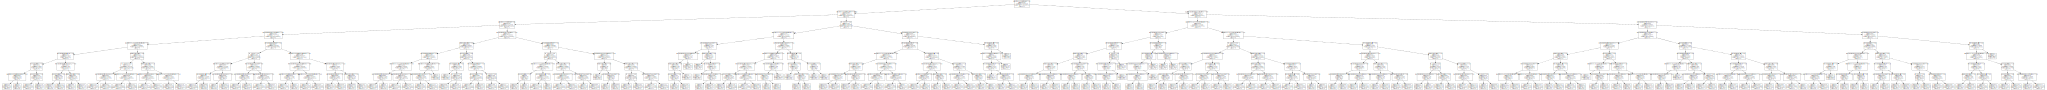

In [373]:
export_graphviz(classification_tree_restaurantDf, 
                out_file = "classification_tree_restaurantDf.dot", 
                feature_names = x_train.columns,
                class_names = targetClassNamesList )

with open("classification_tree_restaurantDf.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

In [374]:
pred = classification_tree_restaurantDf.predict(x_test)

In [375]:
cm = pd.DataFrame(confusion_matrix(y_test, pred).T)

In [376]:
cm

,0,1
0,12,41
1,2093,10485


In [377]:
total = 0; 
for i in range(len(cm)):
     total = total+cm[i][i]

In [378]:
(total)/cm.sum().sum()

0.83105058981870006

# Regression Model

In [105]:
regr_tree_restaurantDf = DecisionTreeRegressor(max_depth = 6)
regr_tree_restaurantDf.fit(x_train, y_train)
predRegr = regr_tree_restaurantDf.predict(x_test)

ValueError: could not convert string to float: 'free'

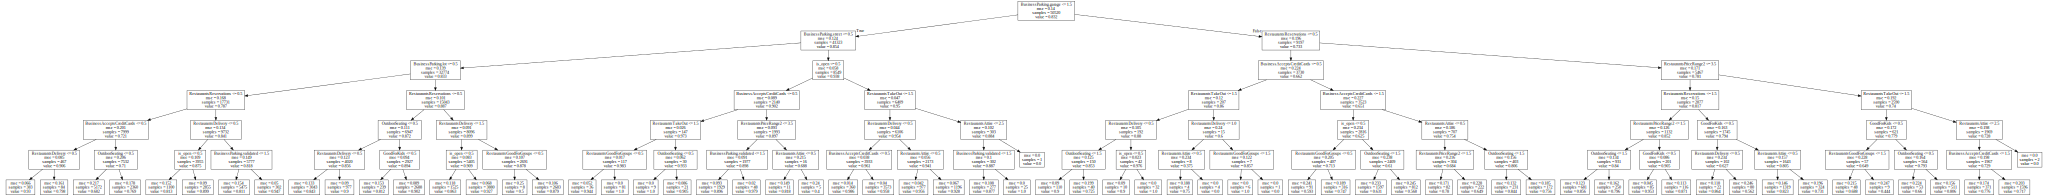

In [380]:
export_graphviz(regr_tree_restaurantDf, 
                out_file = "regr_tree_restaurantDf.dot", 
                feature_names = x_train.columns)

with open("regr_tree_restaurantDf.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

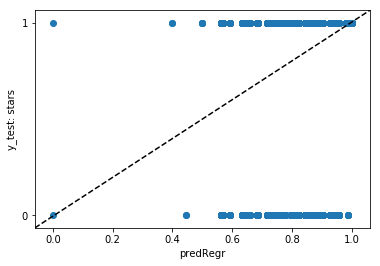

In [381]:
plt.figure(0)
plt.scatter(predRegr, 
            y_test, 
            label = 'stars')

plt.plot([0, 1], 
         [0, 1], 
         '--k', 
         transform = plt.gca().transAxes)

plt.xlabel('predRegr')
plt.ylabel('y_test: stars')

mse = mean_squared_error(y_test, predRegr)
plt.show()

In [382]:
mse 

0.12938718905756597

In [383]:
math.sqrt(mse)

0.3597043078106877

In [384]:
# Random forests: using 6 features
random_forest_ohDfPractice = RandomForestRegressor(max_features = 6, random_state = 1)

random_forest_ohDfPractice.fit(x_train, y_train)

predRandForest = random_forest_ohDfPractice.predict(x_test)
randForestMse = mean_squared_error(y_test, predRandForest)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


In [385]:
print(randForestMse)
print(math.sqrt(randForestMse))

0.136864398928
0.36995188731552253


In [386]:
Importance = pd.DataFrame({'Importance':random_forest_ohDfPractice.feature_importances_*100}, 
                          index = x.columns)

Importance.sort_values(by = 'Importance', 
                       axis = 0, 
                       ascending = True).plot(kind = 'barh', 
                                              color = 'r', )

plt.xlabel('Variable Importance')
plt.gca().legend_ = None

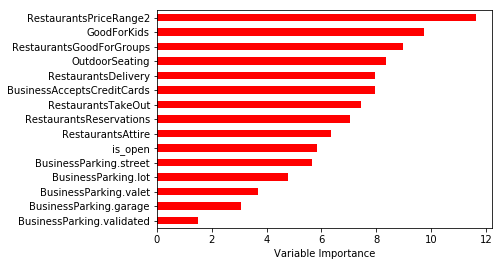

In [387]:
plt.show()